In [1]:

#add other imports here (if any, for example, pytorch)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import train_test_split
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
import time
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, LassoCV, RidgeCV


from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
import scipy.stats as stats
from sklearn.model_selection import train_test_split,cross_val_score

In [2]:
data = pd.read_csv('data.csv')
data = data.drop('TotalOrderQuantity', axis=1)
data = data.drop('AvgUnitPrice', axis=1)

In [3]:
Xdata = data.drop('TotalLineTotal', axis=1)
ydata = data['TotalLineTotal']
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata,test_size=0.5)

In [129]:
scaler = StandardScaler()
XtrainScaled = scaler.fit_transform(Xtrain)
XtestScaled = scaler.fit_transform(Xtest)

In [5]:

pipeline = Pipeline([
  ('scaler', StandardScaler()),
  #('pca', PCA(n_components=3, random_state=42)),
  ('regression', LinearRegression())
])
# Fit the pipeline
pipeline.fit(Xtrain, ytrain)

# Predict 
y_train_pred = pipeline.predict(Xtrain)
y_test_pred = pipeline.predict(Xtest)

# Result
train_r2 = r2_score(ytrain, y_train_pred)
test_r2 = r2_score(ytest, y_test_pred)


print("Training R2:", train_r2)
print("Testing R2:", test_r2)

mae_computed = mean_absolute_error(ytest, y_test_pred)
print("The MAE computed by Sklearn is:\t\t{0}\n".format(mae_computed))
rmse_computed = np.sqrt(mean_squared_error(ytest, y_test_pred))
print("The RMSE computed by Sklearn is:\t{0}\n".format(rmse_computed))

Training R2: 0.030122995839012123
Testing R2: 0.029057532219967763
The MAE computed by Sklearn is:		4282.559331457348

The RMSE computed by Sklearn is:	7686.560888265228



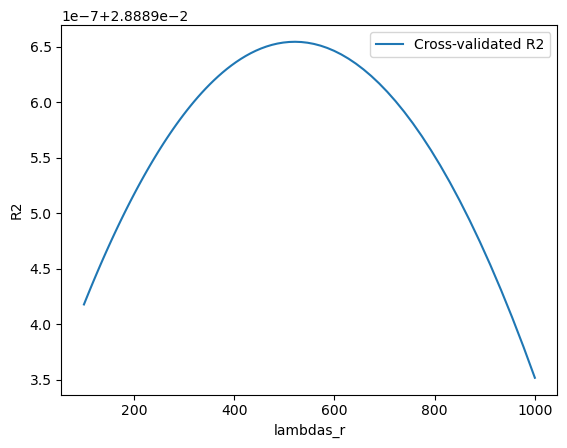

Best lambdas_r: 521.4008287999684


In [139]:

lambdas_r = np.geomspace(100,1000, 100)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', Ridge())
])

kfold = KFold(10)
grid = GridSearchCV(pipeline, cv=kfold, param_grid={'regression__alpha': lambdas_r}, scoring='r2')

grid.fit(Xtrain, ytrain)

plt.plot(lambdas_r, grid.cv_results_['mean_test_score'], label='Cross-validated R2')


plt.xlabel('lambdas_r')
plt.ylabel('R2')
plt.legend()
plt.show()


lambdas_ideal = grid.best_params_['regression__alpha']
print("Best lambdas_r:", lambdas_ideal)


In [132]:

scaler = StandardScaler()

scaler.fit(Xtrain)

X_train_std = scaler.transform(Xtrain)
X_test_std = scaler.transform(Xtest)

lasso = Lasso(random_state=42)

lasso.fit(X_train_std, ytrain)

coefficients = lasso.coef_
intercept = lasso.intercept_

y_pred = lasso.predict(X_test_std)

rmse = mean_squared_error(ytest, y_pred, squared=False)

print("Coefficients:", coefficients)
print("Intercept:", intercept)
print("RMSE:", rmse)
#print("RMSE:", rmse2)

Coefficients: [-786.53156115 -635.47734016 -807.44785966   82.62219573  -79.10569916]
Intercept: 3730.4845684796414
RMSE: 7739.660868181027


In [141]:

alphas = np.geomspace(0.00001,0.1,100)


lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)


lasso_cv.fit(X_train_std, ytrain)

print("Optimal alpha value:", lasso_cv.alpha_)


Optimal alpha value: 1e-05


In [135]:
print(lasso_cv.alpha_)
lasso = Lasso(alpha=lasso_cv.alpha_, random_state=42)

lasso.fit(X_train_std, ytrain)

print("Coefficients:", lasso.coef_)
print("Intercept:", lasso.intercept_)

y_pred = lasso.predict(X_test_std)
rmse = mean_squared_error(ytest, y_pred, squared=False)
print("RMSE:", rmse)


0.001
Coefficients: [-787.57396758 -636.60425213 -808.25157263   83.93506957  -80.45933442]
Intercept: 3730.4845684796414
RMSE: 7739.65606451494



Top-5 most important features:from most to least important
- SalespersonID
- CustomerID
- ProductID
- PromotionID
- AvgDiscount


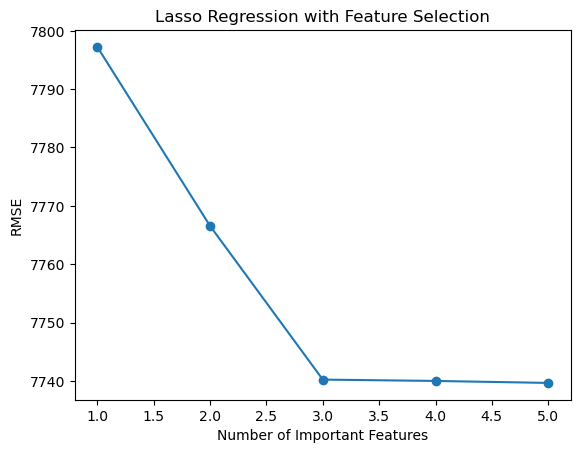

In [136]:
feature_importance = abs(lasso_cv.coef_)

n_features = X_train_std.shape[1]
rmse_list = []
feature_names = Xtrain.columns.tolist()

for n in range(1, n_features+1):

    idx = np.argsort(feature_importance)[::-1][:n]
    selected_features = [feature_names[i] for i in idx]
    

    lasso = Lasso(alpha=lasso_cv.alpha_, random_state=42)
    lasso.fit(X_train_std[:, idx], ytrain)
    

    y_pred = lasso.predict(X_test_std[:, idx])

    rmse = mean_squared_error(ytest, y_pred, squared=False)
    rmse_list.append(rmse)


    if n == n_features:
        print(f"\nTop-{n} most important features:from most to least important")
        for f in selected_features:
            print(f"- {f}")


plt.plot(range(1, n_features+1), rmse_list, marker='o')
plt.xlabel('Number of Important Features')
plt.ylabel('RMSE')
plt.title('Lasso Regression with Feature Selection')
plt.show()


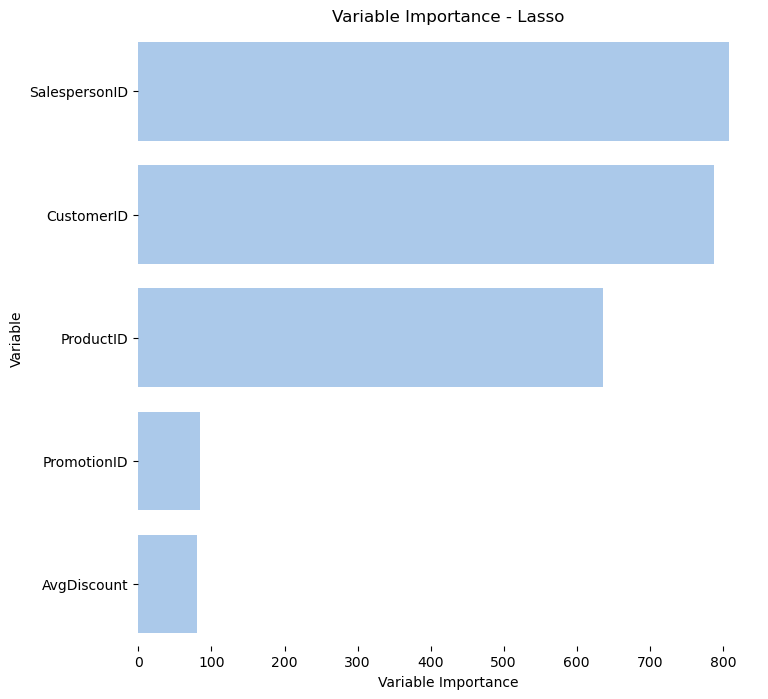

In [143]:

    importances = abs(lasso_cv.coef_)
    indices = np.argsort(importances)[::-1] 
    
    f, ax = plt.subplots(figsize=(8, 8))
    plt.title("Variable Importance - Lasso")
    sns.set_color_codes("pastel")

    sns.barplot(y=[Xtrain.columns[i] for i in indices], x=importances[indices], 
                label="Total", color="b")
    
    ax.set(ylabel="Variable",
           xlabel="Variable Importance")
    
    sns.despine(left=True, bottom=True)

In [159]:

scaler = StandardScaler()

scaler.fit(Xtrain)

X_train_std = scaler.transform(Xtrain)
X_test_std = scaler.transform(Xtest)

ridge = Ridge(random_state=42)

ridge.fit(X_train_std, ytrain)

coefficients = ridge.coef_
intercept = ridge.intercept_

y_pred = ridge.predict(X_test_std)

rmse = mean_squared_error(ytest, y_pred, squared=False)

print("Coefficients:", coefficients)
print("Intercept:", intercept)
print("RMSE:", rmse)
#print("RMSE:", rmse2)


alphas = np.geomspace(0.00001,0.1,100)


ridge_cv = RidgeCV(alphas=alphas, cv=5)


ridge_cv.fit(X_train_std, ytrain)

print("Optimal alpha value:", ridge_cv.alpha_)



mse = np.mean((ridge_cv.predict(X_train_std) - ytrain) ** 2)
mean_rmse = np.sqrt(mse)
log_alphas = ridge_cv.alpha_

print(ridge_cv.alpha_)
ridge = Ridge(alpha=ridge_cv.alpha_, random_state=42)

ridge.fit(X_train_std, ytrain)

print("Coefficients:", ridge.coef_)
print("Intercept:", ridge.intercept_)

y_pred = ridge.predict(X_test_std)
rmse = mean_squared_error(ytest, y_pred, squared=False)
print("RMSE:", rmse)

feature_importance = abs(ridge_cv.coef_)

n_features = X_train_std.shape[1]
rmse_list = []
feature_names = Xtrain.columns.tolist()

for n in range(1, n_features+1):

    idx = np.argsort(feature_importance)[::-1][:n]
    selected_features = [feature_names[i] for i in idx]
    

    ridge = Ridge(alpha=ridge_cv.alpha_, random_state=42)
    ridge.fit(X_train_std[:, idx], ytrain)
    

    y_pred = ridge.predict(X_test_std[:, idx])

    rmse = mean_squared_error(ytest, y_pred, squared=False)
    rmse_list.append(rmse)


    if n == n_features:
        print(f"\nTop-{n} most important features:from most to least important")
        for f in selected_features:
            print(f"- {f}")




Coefficients: [-787.5690865  -636.60046455 -808.24836237   83.9356072   -80.45979324]
Intercept: 3730.4845684796414
RMSE: 7739.65608895423
Optimal alpha value: 0.1
0.1
Coefficients: [-787.57356287 -636.60474659 -808.25213176   83.93617484  -80.46053944]
Intercept: 3730.4845684796414
RMSE: 7739.656064936005

Top-5 most important features:from most to least important
- SalespersonID
- CustomerID
- ProductID
- PromotionID
- AvgDiscount


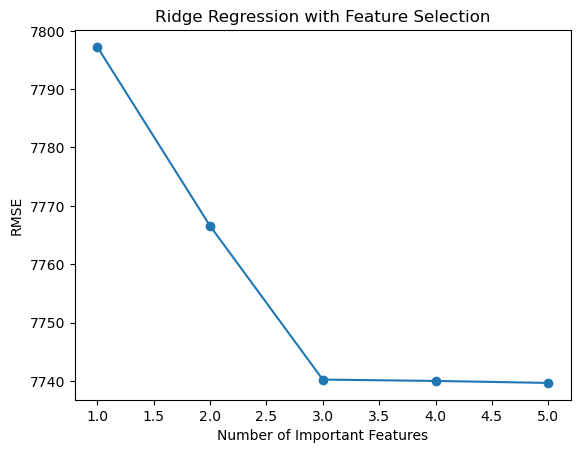

In [160]:


plt.plot(range(1, n_features+1), rmse_list, marker='o')
plt.xlabel('Number of Important Features')
plt.ylabel('RMSE')
plt.title('Ridge Regression with Feature Selection')
plt.show()

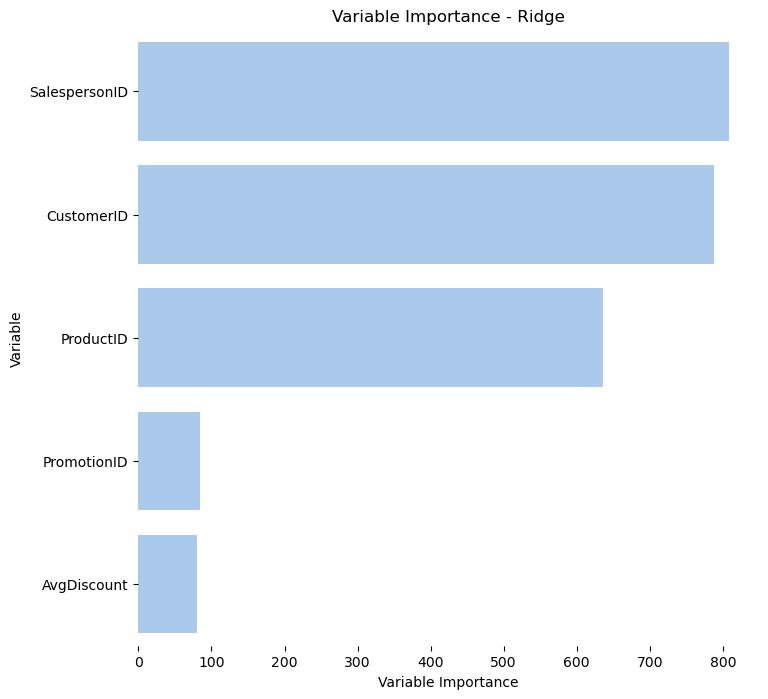

In [161]:


    importances = abs(ridge_cv.coef_)
    indices = np.argsort(importances)[::-1] 
    
    f, ax = plt.subplots(figsize=(8, 8))
    plt.title("Variable Importance - Ridge")
    sns.set_color_codes("pastel")

    sns.barplot(y=[Xtrain.columns[i] for i in indices], x=importances[indices], 
                label="Total", color="b")
    
    ax.set(ylabel="Variable",
           xlabel="Variable Importance")
    
    sns.despine(left=True, bottom=True)

In [6]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# PolynomialFeatures
poly_reg = Pipeline([
        ('poly', PolynomialFeatures(degree=2)),  # 使用二次多项式特征
        ('scaler', StandardScaler()),  # 使用StandardScaler对数据进行特征缩放
        ('reg', LinearRegression())  # 线性回归模型
    ])

poly_reg.fit(Xtrain, ytrain)

ypred = poly_reg.predict(Xtest)

r2 = r2_score(ytest, ypred)
print('R^2 score:', r2)


R^2 score: 0.0751948297565116


In [10]:
#Random Forest
clf = RandomForestRegressor()
scores = cross_val_score(clf, Xtrain, ytrain, cv=3,scoring='neg_mean_squared_error') # 3-fold cross-validation
print("MSE:"+ str(-scores.mean()))

MSE:23551.193642671144


In [4]:
from sklearn.metrics import mean_squared_error
import numpy as np

clf = RandomForestRegressor()
clf.fit(Xtrain, ytrain)

# Predict on test set
ypred = clf.predict(Xtest)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(ytest, ypred))
print("RMSE:", rmse)


RMSE: 36.37057159331105


In [ ]:
scaler = StandardScaler()
XtrainScaled = scaler.fit_transform(Xtrain)
XtestScaled = scaler.fit_transform(Xtest)

In [ ]:
#SVM
clf = SVR()
scores = cross_val_score(clf, Xtrain, ytrain, cv=3,scoring='neg_mean_squared_error')
print("MSE:"+ str(-scores.mean()))

In [4]:
from sklearn.metrics import mean_squared_error
import numpy as np

clf = SVR()
clf.fit(Xtrain, ytrain)

# Predict on test set
ypred = clf.predict(Xtest)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(ytest, ypred))
print("RMSE:", rmse)

RMSE: 8214.158403525327


In [ ]:
#KNN
clf = KNeighborsRegressor()
scores = cross_val_score(clf, Xtrain, ytrain, cv=3,scoring='neg_mean_squared_error')
print("MSE:"+ str(-scores.mean()))

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

clf = KNeighborsRegressor()
clf.fit(Xtrain, ytrain)

# Predict on test set
ypred = clf.predict(Xtest)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(ytest, ypred))
print("RMSE:", rmse)

In [ ]:
#ANN
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
def ANN(optimizer = 'adam',neurons=32,batch_size=32,epochs=50,activation='relu',patience=5,loss='mse'):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(X.shape[1],), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer = optimizer, loss=loss)
    early_stopping = EarlyStopping(monitor="loss", patience = patience)# early stop patience
    history = model.fit(X, y,
              batch_size=batch_size,
              epochs=epochs,
              callbacks = [early_stopping],
              verbose=0) #verbose set to 1 will show the training process
    return model

In [ ]:
clf = KerasRegressor(build_fn=ANN, verbose=0)
scores = cross_val_score(clf, X, y, cv=3,scoring='neg_mean_squared_error')
print("MSE:"+ str(-scores.mean()))